# Store Sales 
Use time series forecating and machine learning to predict grocery sales. Predict sales for the thousands of product families sold at Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. More accurate forecasting can decrease food waste related to overstocking and improve customer satisfaction. 

# Datasets 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from statistics import mean
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.datasets import make_classification
from sklearn import ensemble
import sklearn.metrics as metrics
import time

train=r'/kaggle/input/store-sales-time-series-forecasting/train.csv'
test=r'/kaggle/input/store-sales-time-series-forecasting/test.csv'
transaction=r'/kaggle/input/store-sales-time-series-forecasting/transactions.csv'
stores=r'/kaggle/input/store-sales-time-series-forecasting/stores.csv'
oil=r'/kaggle/input/store-sales-time-series-forecasting/oil.csv'
event=r'/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv'

# Train Dataset
The shape of the train dataset is 3,000,888 rows × 6 columns. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers.

In [2]:
train=pd.read_csv(train)
print(train.shape) #(3000888, 6)
train.head(10)

(3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0
5,5,2013-01-01,1,BREAD/BAKERY,0.0,0
6,6,2013-01-01,1,CELEBRATION,0.0,0
7,7,2013-01-01,1,CLEANING,0.0,0
8,8,2013-01-01,1,DAIRY,0.0,0
9,9,2013-01-01,1,DELI,0.0,0


In [3]:
train = train[train.sales != 0]
train.head()

,id,date,store_nbr,family,sales,onpromotion
563,563,2013-01-01,25,BEAUTY,2.000,0
564,564,2013-01-01,25,BEVERAGES,810.000,0
566,566,2013-01-01,25,BREAD/BAKERY,180.589,0
568,568,2013-01-01,25,CLEANING,186.000,0
569,569,2013-01-01,25,DAIRY,143.000,0


# Feature Engineer Train Data
Create new features including year, month, and day.

In [4]:
import datetime as dt
from datetime import datetime

#train['year']=train['date'].apply(lambda x: int(str(x)[:4])) #first four
train['month']=train['date'].apply(lambda x: int(str(x)[5:7])) #five and six
#train['day']=train['date'].apply(lambda x: int(str(x)[-2:])) # last two
train['sales'].astype(int)
train.head()

,id,date,store_nbr,family,sales,onpromotion,month
563,563,2013-01-01,25,BEAUTY,2.000,0,1
564,564,2013-01-01,25,BEVERAGES,810.000,0,1
566,566,2013-01-01,25,BREAD/BAKERY,180.589,0,1
568,568,2013-01-01,25,CLEANING,186.000,0,1
569,569,2013-01-01,25,DAIRY,143.000,0,1


In [5]:
train.dtypes

id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
month            int64
dtype: object

# Correlations
On a side note, AUC for logistic regression for onpromotions was: 0.8779. Therefore, promotions play a very significant part of sales. 

In [6]:
train.corr()

,id,store_nbr,sales,onpromotion,month
id,1.000000,0.016540,0.031160,0.208065,0.038940
store_nbr,0.016540,1.000000,0.061742,0.016210,0.003357
sales,0.031160,0.061742,1.000000,0.410608,0.012308
onpromotion,0.208065,0.016210,0.410608,1.000000,0.023665
month,0.038940,0.003357,0.012308,0.023665,1.000000


# Events Data

In [7]:
event=pd.read_csv(event)
print(event.shape) #(3000888, 6)
event.head(10)

(350, 6)


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
6,2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,False


# Transactions 
The original transaction dataset is 83488 rows × 3 columns. There was no missing data.

In [8]:
tDF=pd.read_csv(transaction)
tDF.drop_duplicates() 
tDF.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False) 
tDF.head() 

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [9]:
#Feature three new columns with year, month, and day:
tDF['year']=tDF['date'].apply(lambda x: int(str(x)[:4])) #first four
tDF['month']=tDF['date'].apply(lambda x: int(str(x)[5:7])) #five and six
tDF['day']=tDF['date'].apply(lambda x: int(str(x)[-2:])) # last two

#Verify the new columns are setup correctly:
#print(tDF['day'].unique()) # Correctly prints numbers 1 to 31
#print(tDF['month'].unique()) # [ 1  2  3  4  5  6  7  8  9 10 11 12]
#print(tDF['year'].unique()) # [2013 2014 2015 2016 2017]

tDF.head() 

,date,store_nbr,transactions,year,month,day
0,2013-01-01,25,770,2013,1,1
1,2013-01-02,1,2111,2013,1,2
2,2013-01-02,2,2358,2013,1,2
3,2013-01-02,3,3487,2013,1,2
4,2013-01-02,4,1922,2013,1,2


In [10]:
tDF.dtypes

date            object
store_nbr        int64
transactions     int64
year             int64
month            int64
day              int64
dtype: object

# Find Missing Values

In [11]:
#search for columns with missing values:
def findNA():
    print("Missing data by column as a percent:")
    findNA=train.isnull().sum().sort_values(ascending=False)/len(train)
    print(findNA.head())
findNA() 

Missing data by column as a percent:
id           0.0
date         0.0
store_nbr    0.0
family       0.0
sales        0.0
dtype: float64


# Yearly Sales
The graph clearly shows that sales went down in 2017. This is not a good trend. Prior to 2017, sales were mostly flat from years 2013 to 2016. There is a negative correlation, -.57 which verifies that sales are decreasing.  

   year  transactions
0  2013      29107173
1  2014      30006929
2  2015      31312370
3  2016      31052337
4  2017      20000136


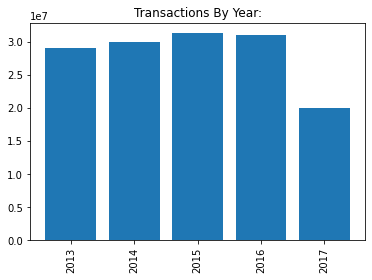

-0.5752  is the correlations between year and transactions


In [12]:
yearGb=tDF.groupby('year')['transactions'].sum().reset_index()
print(yearGb)
x=yearGb['year']
y=yearGb['transactions']
plt.title("Transactions By Year:")
plt.xticks(rotation=90)
plt.bar(x,y)
plt.show()

yearCorr=x.corr(y).round(4)
print(yearCorr, " is the correlations between year and transactions")

# Monthly Sales 
Sales are the least in September, October, and November. The rest of the months are fairly similiar. Surprisingly, December did not have the highest sales as normally that is when stores have most of their sales from Christmas.

    month  transactions
0       1      12156198
1       2      11707934
2       3      12917913
3       4      12633531
4       5      13112679
5       6      12482179
6       7      12827206
7       8      11545571
8       9       9811819
9      10      10048234
10     11       9877873
11     12      12357808


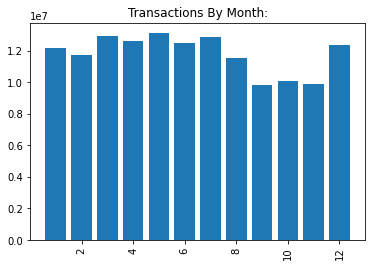

-0.545  is the correlations between month and transactions


In [13]:
monthGb=tDF.groupby('month')['transactions'].sum().reset_index()
print(monthGb)
x=monthGb['month']
y=monthGb['transactions']
plt.title("Transactions By Month:")
plt.xticks(rotation=90)
plt.bar(x,y)
plt.show()

monthCorr=x.corr(y).round(4)
print(monthCorr, " is the correlations between month and transactions")

# Family

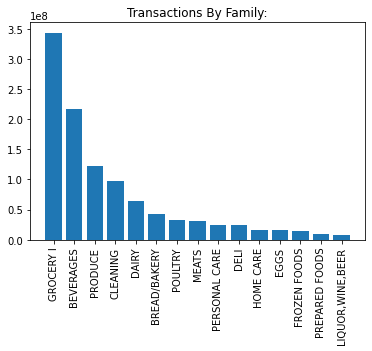

In [14]:
famGb=train.groupby('family')['sales'].sum().reset_index().sort_values('sales', ascending=False).head(15)
#print(famGb)
x=famGb['family']
y=famGb['sales']
plt.title("Transactions By Family:")
plt.xticks(rotation=90)
plt.bar(x,y)
plt.show()

# Numeric DataFrame

In [15]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
train = train.select_dtypes(include=numerics)
train.head()

,id,store_nbr,sales,onpromotion,month
563,563,25,2.000,0,1
564,564,25,810.000,0,1
566,566,25,180.589,0,1
568,568,25,186.000,0,1
569,569,25,143.000,0,1


# Split Data

In [16]:
X=train.drop('sales', axis=1)
y=train['sales']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.30, random_state = 42)

# Linear Regression

Linear regression r2 score:  0.1774
Linear Accuracy:  0.1774
0.1388  linear regression cross validate mean
1186.8782  is lr MSE 


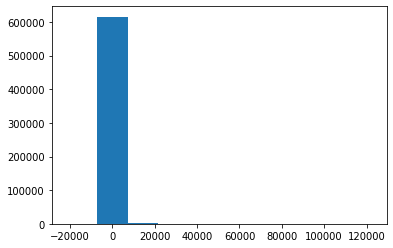

In [17]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

#Fit and predict:
lrModel = LinearRegression()
lrModel.fit(X_train, y_train)
lrPredict = lrModel.predict(X_test)

# plt.scatter(y_test, predictions)
plt.hist(y_test - lrPredict)

#Linear Metrics:
#auc = round( metrics.roc_auc_score(y_test, lrPredict), 4 ) 
r2 = r2_score(y_test, lrPredict).round(4) 
#print("AUC for linear regression is: ", auc)
print("Linear regression r2 score: ", r2)

#CROSS VALIDATE TEST RESULTS:
lr_score = lrModel.score(X_test, y_test).round(4)  # train test 
print("Linear Accuracy: ", lr_score)
lr_cv = cross_validate(lrModel, X, y, cv = 5, scoring= 'r2')
lr_cvMean=lr_cv['test_score'].mean().round(4)
print(lr_cvMean, " linear regression cross validate mean")

lrMSE=np.sqrt(metrics.mean_squared_error(y_test, lrPredict))
print(round(lrMSE, 4), " is lr MSE ")

# Decision Tree
When the automation parameters runs, the higher than max_depth and max_leaf_nodes the better the r-squared with the least amount of error. 

In [18]:
from sklearn.tree import DecisionTreeRegressor

#FIND best_tree_size LEAF NODES:
def calcLeaf():
    candidate_max_leaf_nodes = [5, 25, 50, 100, 250, 500]
    maeDic={} #dictionary  key=leaf  mae=value
    for leaf in candidate_max_leaf_nodes:
        model = DecisionTreeRegressor(max_leaf_nodes=leaf, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(4)
        maeDic[leaf]=mae
    print(maeDic)
    best_tree_size = sorted(maeDic, key=lambda x : maeDic[x])[0]
    print(best_tree_size)
    
def calcDepth():
    max_depth_list = [2, 3, 5, 7, 9, 10, 12]
    maeDic={} #dictionary  key=depth  mae=value
    for d in max_depth_list:
        model = DecisionTreeRegressor(max_leaf_nodes=100, max_depth=d, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(4)
        maeDic[d]=mae
    print(maeDic)
    best_max_depth = sorted(maeDic, key=lambda x : maeDic[x])[0]
    print(best_max_depth, " best max_depth with least error.") #10
    
def automateTree():
    print("Decision Tree Automating:")
    start=time.time()
    candidate_max_leaf_nodes = [5, 50, 100, 250, 500]
    max_depth_list = [2, 3, 5, 7, 9, 11]
    
    #STORE DATA INTO LISTS FOR DATAFRAME LATER:
    aucList=[]
    maeList=[]
    maxDepthList=[]
    maxLeafNodesList=[]

    for d in max_depth_list:
        for leaf in candidate_max_leaf_nodes:
            model = DecisionTreeRegressor(max_leaf_nodes=leaf, max_depth=d, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mae = mean_absolute_error(y_test, y_pred).round(4)
            treeR2 = r2_score(y_test, y_pred).round(4)
            
            aucList.append(treeR2)
            maeList.append(mae)
            maxDepthList.append(d)
            maxLeafNodesList.append(leaf)
           
    df = pd.DataFrame(list(zip(aucList, maeList, maxDepthList, maxLeafNodesList)),
                          columns=['AUC','MAE', 'MaxDepth', 'MaxLeafNodes'])
    
    df=df.sort_values(by=['MAE'], ascending=False)
    print("Done. ", round(time.time()-start,4), " seconds")
    return df

#treeDF=automateTree()    
#treeDF.head(50)

#### Decision tree make prediction
Input best_tree_size and best_depth from above functions. 
High accuracy does not equal high score. Best scores seem to take account error as well into account.

In [19]:
best_tree_size=100
best_depth=11

tree = DecisionTreeRegressor(max_leaf_nodes=best_tree_size, max_depth=best_depth, random_state=42)
tree.fit(X, y)
y_pred = tree.predict(X_test)

#AUC and r2 metric
tree_r2 = r2_score(y_test, y_pred).round(4)
print("Decision Tree r-squared is:", tree_r2)

def printReports(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

Decision Tree r-squared is: 0.3894


# Gradient Boost
The bigger max_depth, the better r-squared with less error:
* 2  max_depth || GB reg r2:  0.0409 || MSE: 1174813.7646
* 3  max_depth || GB reg r2:  0.0505 || MSE: 1163011.2060
* 4  max_depth || GB reg r2:  0.057 || MSE: 1155141.4139
* 5  max_depth || GB reg r2:  0.0641 || MSE: 1146393.4473
* 7  max_depth || GB reg r2:  0.0723 || MSE: 1136326.4514

The more n_estimators, the better r-squared with less error:
* 2 n_estimators || GB regression r2:  0.0088 || MSE: 1214127.5659
* 50 n_estimators || GB regression r2:  0.152 || MSE: 1038709.6658
* 100 n_estimators || GB regression r2:  0.217 || MSE: 959162.1316
* 200 n_estimators || GB regression r2:  0.2681 || MSE: 896548.3199
* 300 n_estimators || GB regression r2:  0.2927 || MSE: 866340.3620
* 400 n_estimators || GB regression r2:  0.308 || MSE: 847675.8794
* 500 n_estimators || GB regression r2:  0.3184 || MSE: 834923.8771

In [20]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor

def gbDepth():
    depthList=[2, 3, 4, 5, 7]
    print("staring max_depth calculations:")
    for d in depthList:
        params = {
         "n_estimators": 10, "max_depth": d, 
            "min_samples_split": 5, "learning_rate": 0.01,
        }

        #Fit and Predict:
        reg = ensemble.GradientBoostingRegressor(**params)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        gbr_r2 = r2_score(y_test, y_pred).round(4) 
        mse = mean_squared_error(y_test, reg.predict(X_test))
        print(d, " max_depth || GB reg r2: ", gbr_r2, "|| MSE: {:.4f}".format(mse)) 

def gbN():
    nList=[2, 50, 100, 200, 300, 400, 500]
    print("starting GB n_estimators calculations:")
    for n in nList:
        params = {
         "n_estimators": n, "max_depth": 2, 
            "min_samples_split": 5, "learning_rate": 0.01,
        }

        #Fit and Predict:
        reg = ensemble.GradientBoostingRegressor(**params)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        gbr_r2 = r2_score(y_test, y_pred).round(4) 
        mse = mean_squared_error(y_test, reg.predict(X_test))
        print(n, "n_estimators || GB regression r2: ", gbr_r2, "|| MSE: {:.4f}".format(mse)) 

def gbSplit():
    sList=[2, 3, 5, 7]
    
    for s in sList:
        params = {
         "n_estimators": 500, "max_depth": 2,
            "min_samples_split": s, "learning_rate": 0.01,
        }

        #Fit and Predict:
        reg = ensemble.GradientBoostingRegressor(**params)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        gbr_r2 = r2_score(y_test, y_pred).round(4)
        mse = mean_squared_error(y_test, reg.predict(X_test)).round(4)
        print(s," min_samples_splits || R2 ", gbr_r2, " || MSE {:.4f}".format(mse))

#Turn on or off functions here:
#gbDepth()
#gbN()
#gbSplit()

#### Gradient Boost Prediction
Use functions above to find the best paramters to input below.

In [21]:
def gb():
    params = {
     "n_estimators": 500, "max_depth": 7, 
        "min_samples_split": 3, "learning_rate": 0.01,
    }

    #Fit and Predict:
    reg = ensemble.GradientBoostingRegressor(**params)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    gbr_r2 = r2_score(y_test, y_pred).round(4) 
    print("Gradient boosting regression r2: ", gbr_r2) 

    mse = mean_squared_error(y_test, reg.predict(X_test))
    print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

# Random Forest
Random forest is too slow for n_estimators above 100 to test for error.

In [22]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

#Check for Error and find Best n_estimators:
def checkMAE():
    dMAE={} #dictionary of n_estimators as key and MAE as value:
    for n in range(2, 601, 100):
        forest = RandomForestRegressor(n_estimators=n, random_state = 0)
        forest.fit(X_train, y_train)
        y_pred = forest.predict(X_test)
        MAE=metrics.mean_absolute_error(y_test, y_pred).round(2)
        #forest_auc = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
        dMAE[n]=MAE
        print(n, " n_estimates |", MAE, " MAE")
    dMAE=sorted(((v, k) for k, v in dMAE.items()), reverse=False)
    print(dMAE)
#checkMAE() 

## Final Forest Prediction

In [23]:
forestEst=2
forest = RandomForestRegressor(n_estimators=forestEst, random_state = 0)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

#Print Metrics:
forest_r2 = r2_score(y_test, y_pred).round(4)   
print("Random forest r2: ", forest_r2)

mae=metrics.mean_absolute_error(y_test, y_pred).round(2)
print("Random forest MAE: ", mae)

Random forest r2:  0.1438
Random forest MAE:  523.7


# Support Vector 
The initial results for SVM AUC with no parameter tunning is 0.5336.  The model does not seem worth investing lots of time into due to poor AUC performance. 

#### GridSearch Tune
The best parameters from tunning SVM is SVC(C=1000, gamma=0.0001).

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
 
def tuneSVM():
    # defining parameter range
    param_grid = {'C': [0.1, 1, 10, 100, 1000],
                  'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                  'kernel': ['linear']}

    grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

    # fitting the model for grid search
    grid.fit(X_train, y_train)

    # print best parameter after tuning
    print(grid.best_params_)

    # print how our model looks after hyper-parameter tuning
    print(grid.best_estimator_)
#tuneSVM()

In [25]:
def runSVR():
    from sklearn.svm import SVR

    #3 Feature Scaling
    from sklearn.preprocessing import StandardScaler
    sc_X = StandardScaler()
    sc_y = StandardScaler()
    X = sc_X.fit_transform(X_train)
    y = sc_y.fit_transform(y_train)

    regressor = SVR()
    regressor.fit(x.reshape(-1, 1), y)
    y_pred = regressor.predict(6.5)

    svmR2 = r2_score(y_test, svmPedict).round(4) 
    svmMAE=metrics.mean_absolute_error(y_test, svmPedict)
    print("SVM r2: ", svmR2, " || MAE: ", svmMAE) 
    
    #GRAPH:
    plt.figure(figsize=(5, 7))
    ax = sns.distplot(y, hist=False, color="r", label="Actual Value")
    sns.distplot(y_test, hist=False, color="b", label="Fitted Values" , ax=ax)
    plt.title('Actual vs Fitted Values')
    plt.show()
    plt.close()

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
#Fit and Predict:
def runSVM():
    svm=SVC(C=1000, gamma=0.0001, kernel = 'linear')
    svm.fit(X_train, y_train)
    svmPedict = svm.predict(X_test)

    svmR2 = r2_score(y_test, svmPedict).round(4) 
    svmMAE=metrics.mean_absolute_error(y_test, svmPedict)
    print("SVM r2: ", svmR2, " || MAE: ", svmMAE) 

    plt.figure(figsize=(5, 7))
    ax = sns.distplot(y, hist=False, color="r", label="Actual Value")
    sns.distplot(y_test, hist=False, color="b", label="Fitted Values" , ax=ax)
    plt.title('Actual vs Fitted Values')
    plt.show()
    plt.close()
#runSVM()

# Test Dataset

In [27]:
test=pd.read_csv(test)
test.head()

#Feature three new columns with year, month, and day:
#test['year']=test['date'].apply(lambda x: int(str(x)[:4])) #first four
test['month']=test['date'].apply(lambda x: int(str(x)[5:7])) #five and six
#test['day']=test['date'].apply(lambda x: int(str(x)[-2:])) # last two

features=list(X.columns)
test=test[features]
test.head()

,id,store_nbr,onpromotion,month
0,3000888,1,0,8
1,3000889,1,0,8
2,3000890,1,2,8
3,3000891,1,20,8
4,3000892,1,0,8


# Final Prediction

In [28]:
finalPredicts=forest.predict(test)
ID=test['id']
tupleData = list(zip(ID, finalPredicts))
output = pd.DataFrame(tupleData, columns = ['id', 'sales'])
output.head(7)

,id,sales
0,3000888,26.2435
1,3000889,26.2435
2,3000890,139.3275
3,3000891,602.0000
4,3000892,26.2435
5,3000893,659.0000
6,3000894,26.2435


#### Save Output

In [29]:
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [30]:
#SAPMLE ONLY:
sample=r'/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv'
sample=pd.read_csv(sample)
sample.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0
